In [1]:
from pathlib import Path
import numpy as np
import json
import cvxpy as cp

import torch
import torch
from src.problems.utils import sample_data_for_group
from src.problems.problems import compute_producer_optimal_solution, _compute_consumer_optimal_solution_cvar
from src.problems.gradient_problem import compute_consumer_optimal_solution_cvar_grad

In [2]:
DATA_PATH_ROOT = Path("../../data")

In [3]:
# load data
with open(DATA_PATH_ROOT / "amazon_predictions.npy", "rb") as f:
    REL_MATRIX = np.load(f)

with open(DATA_PATH_ROOT / "amazon_user_groups.json", "r") as f:
    GROUPS_MAP = json.load(f)

In [4]:
N_CONSUMERS = 400
N_PRODUCERS = 400

In [5]:
sampled_matrix, consumer_ids, group_assignments = sample_data_for_group(
    n_consumers=N_CONSUMERS,
    n_producers=N_PRODUCERS,
    groups_map=GROUPS_MAP,
    group_key="top_category",
    data=REL_MATRIX,
    seed=1
)

In [6]:
compute_producer_optimal_solution(
    rel_matrix=sampled_matrix,
    k_rec=10,
)

pressed CTRL-C 1 times (5 times for forcing termination)


SolverError: Solver 'SCIP' failed. Try another solver, or solve with verbose=True for more information.

In [7]:
_, cvar_allocations = _compute_consumer_optimal_solution_cvar(
    rel_matrix=sampled_matrix,
    k_rec=10,
    producer_max_min_utility=10,
    group_assignments=group_assignments,
    gamma=0.5,
    alpha=0.5,
    solver=cp.SCIP
)

Restricted license - for non-production use only - expires 2026-11-23


SolverError: Solver 'GUROBI' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
cvar_allocations = cvar_allocations.astype(int)

In [ ]:
np.mean(np.sum(cvar_allocations * sampled_matrix, axis=1)) / 10

np.float64(0.9445202392750154)

In [9]:
allocations, losses = compute_consumer_optimal_solution_cvar_grad(
    rel_matrix=sampled_matrix,
    k_rec=10,
    producer_max_min_utility=10,
    gamma=0.5,
    group_assignments=group_assignments,
    alpha=0.5,
    hidden_dim=200,
    max_epochs=30000,
    verbose=True,
    max_patience=5
)

Epoch     1 — loss: 36099.9727, util: 0.00, card: 36099.9102, prod: 0.0000, bin: 0.0625, rho: -0.0010, tau: 0.9990, grad: 5.0000
Epoch   500 — loss: 0.0654, util: 0.05, card: 0.0132, prod: 0.0001, bin: 0.0009, rho: -0.0060, tau: 0.6064, grad: 0.3438
Epoch  1000 — loss: 0.0709, util: 0.06, card: 0.0052, prod: 0.0011, bin: 0.0005, rho: -0.0060, tau: 0.3677, grad: 2.1181
Epoch  1500 — loss: 0.0540, util: 0.04, card: 0.0134, prod: 0.0001, bin: 0.0004, rho: -0.0060, tau: 0.2230, grad: 0.3462
Epoch  2000 — loss: 0.0487, util: 0.04, card: 0.0099, prod: 0.0005, bin: 0.0005, rho: -0.0060, tau: 0.1352, grad: 0.6849
Epoch  2500 — loss: 0.0360, util: 0.03, card: 0.0095, prod: 0.0000, bin: 0.0005, rho: -0.0060, tau: 0.0820, grad: 0.3804
Epoch  3000 — loss: 0.0295, util: 0.02, card: 0.0039, prod: 0.0004, bin: 0.0007, rho: -0.0060, tau: 0.0497, grad: 1.4401
Epoch  3500 — loss: 0.0245, util: 0.02, card: 0.0048, prod: 0.0000, bin: 0.0010, rho: -0.0060, tau: 0.0301, grad: 0.4620
Epoch  4000 — loss: 0.02

In [18]:
import matplotlib.pyplot as plt


In [10]:
losses = np.array(losses) + 1e-20
losses_names = ["$\mathcal{L}$", "$\mathcal{L}_{\mathrm{util}}$", "$\mathcal{L}_{\mathrm{card}}$", "$\mathcal{L}_{\mathrm{prod}}$", "$\mathcal{L}_{\mathrm{bin}}$", "$\eta$"]

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\e'
/var/folders/9l/_y964wyn5fx6bcqmbqjpd9780000gp/T/ipykernel_73460/2215856669.py:2: SyntaxWarning: invalid escape sequence '\m'
  losses_names = ["$\mathcal{L}$", "$\mathcal{L}_{\mathrm{util}}$", "$\mathcal{L}_{\mathrm{card}}$", "$\mathcal{L}_{\mathrm{prod}}$", "$\mathcal{L}_{\mathrm{bin}}$", "$\eta$"]
/var/folders/9l/_y964wyn5fx6bcqmbqjpd9780000gp/T/ipykernel_73460/2215856669.py:2: SyntaxWarning: i

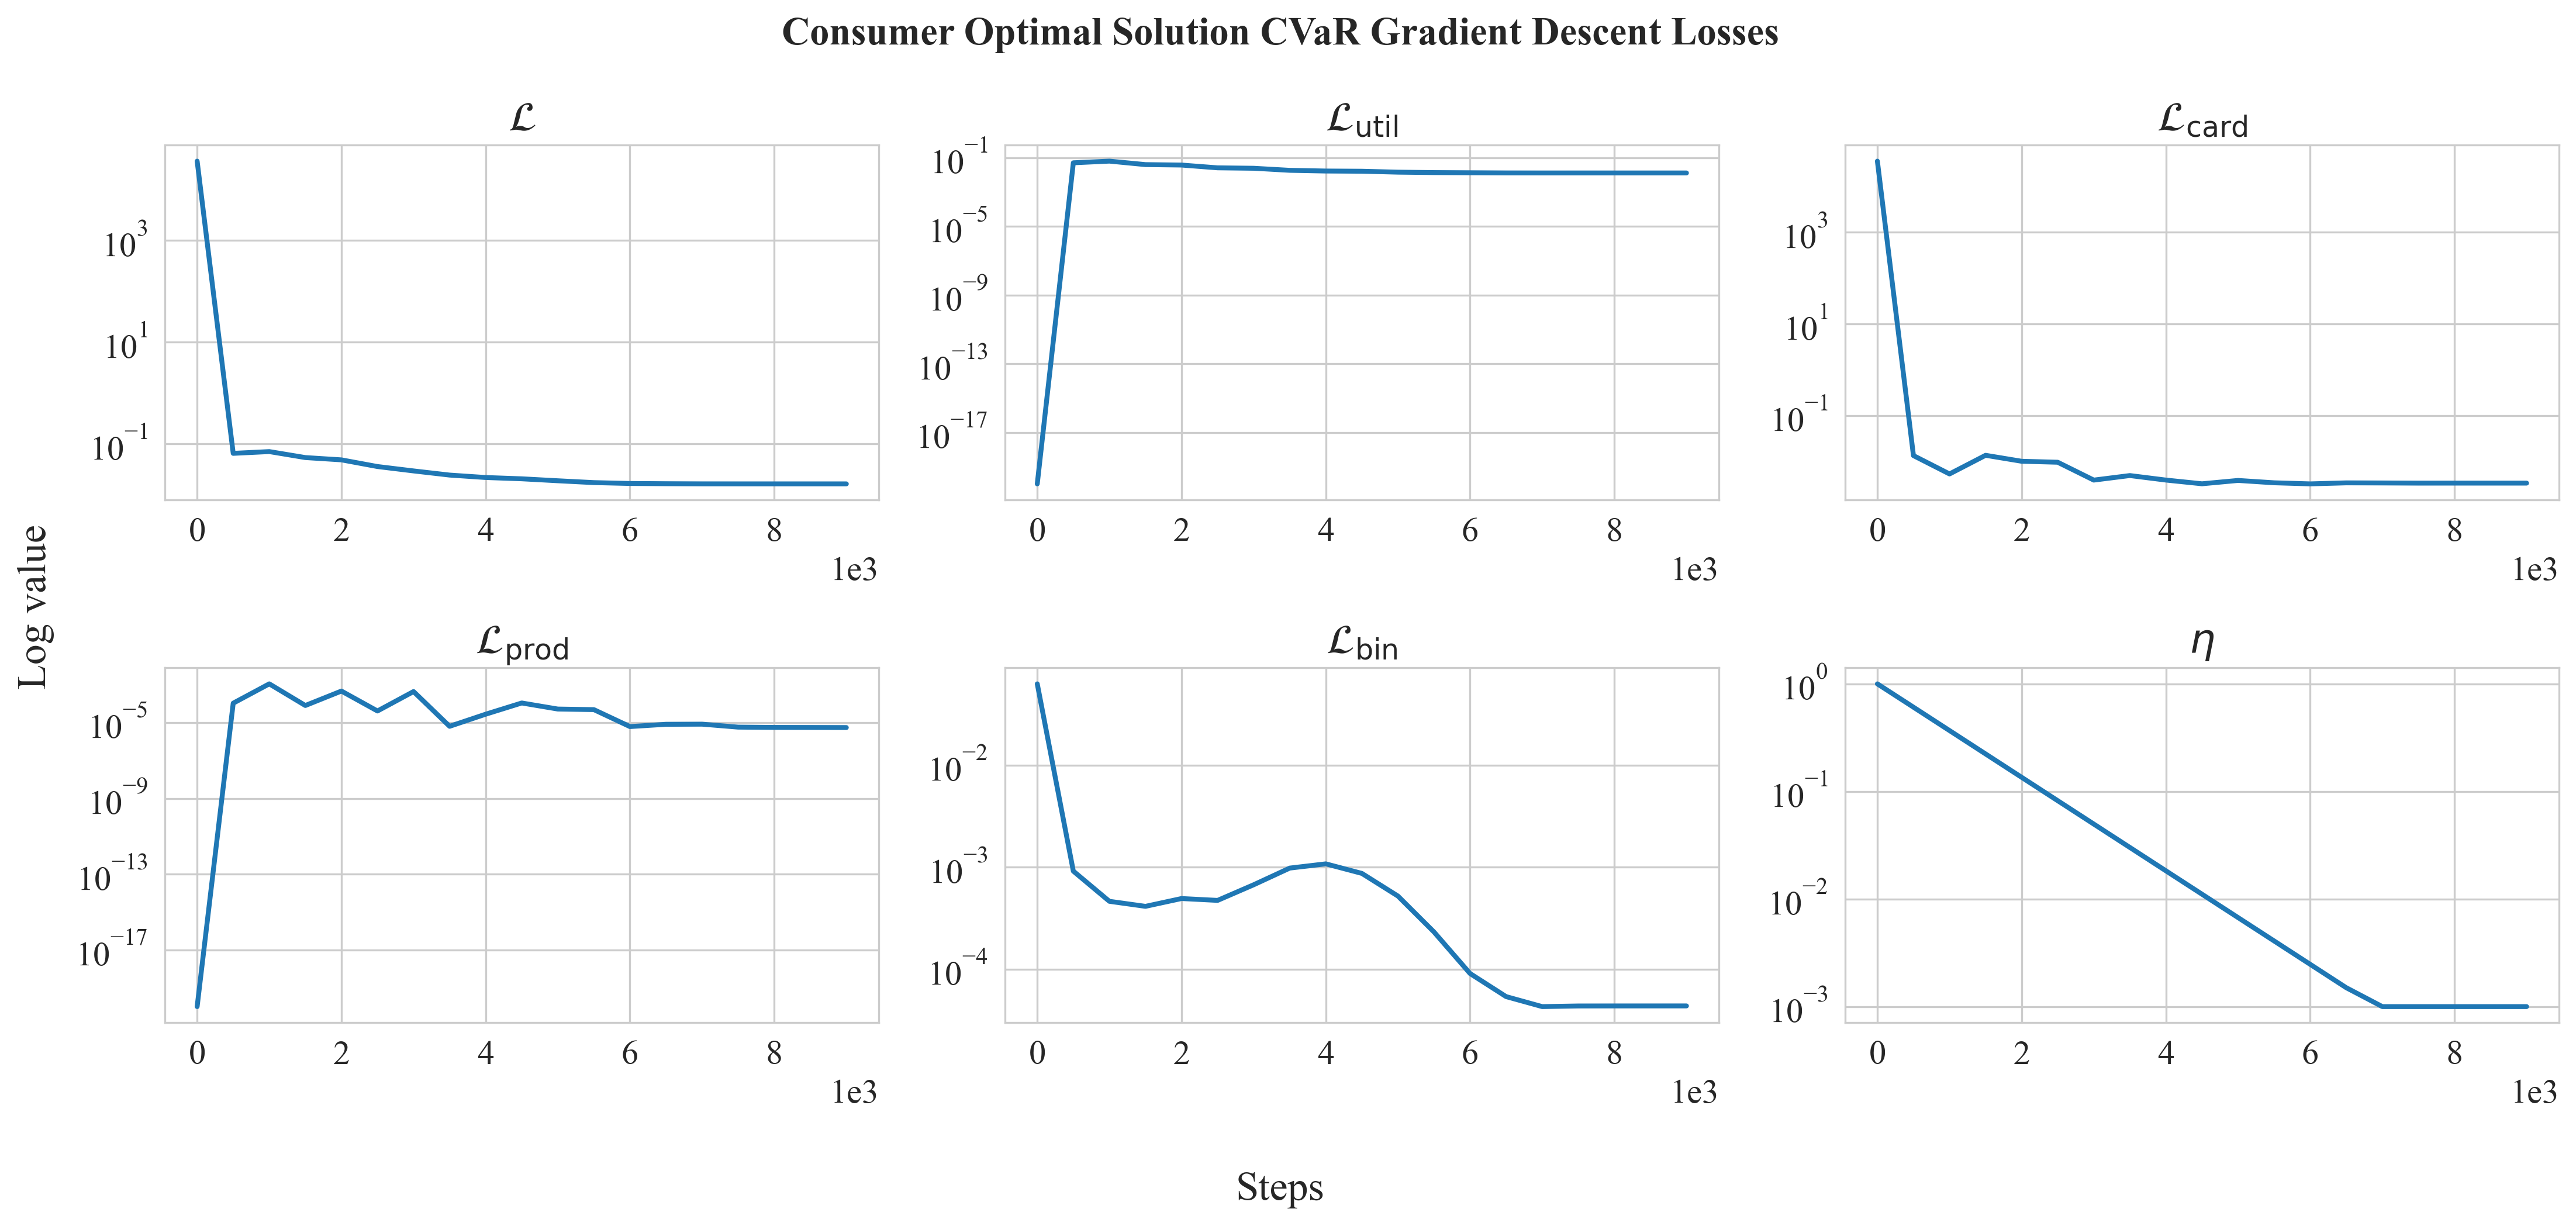

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

mpl.rc('font', **{'size': 14})
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Times New Roman"

fig, axs = plt.subplots(2, 3, figsize=(15, 7), dpi=300)
axs = axs.flatten()  # turn the 3×2 array into a length-6 list
x_vals = np.arange(len(losses)) * 500

for i, ax in enumerate(axs):
    y = losses[:, i]
    low, high = np.percentile(y, [1, 99])
    ax.plot(x_vals, losses[:, i], label=losses_names[i], linewidth=2)
    ax.set_title(losses_names[i])
    ax.set_yscale('log')
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

fig.suptitle("Consumer Optimal Solution CVaR Gradient Descent Losses", fontsize=16, fontweight='bold')
fig.supxlabel("Steps")
fig.supylabel("Log value")

plt.tight_layout()
plt.savefig("consumer_optimal_solution_cvar_losses.pdf", dpi=300)


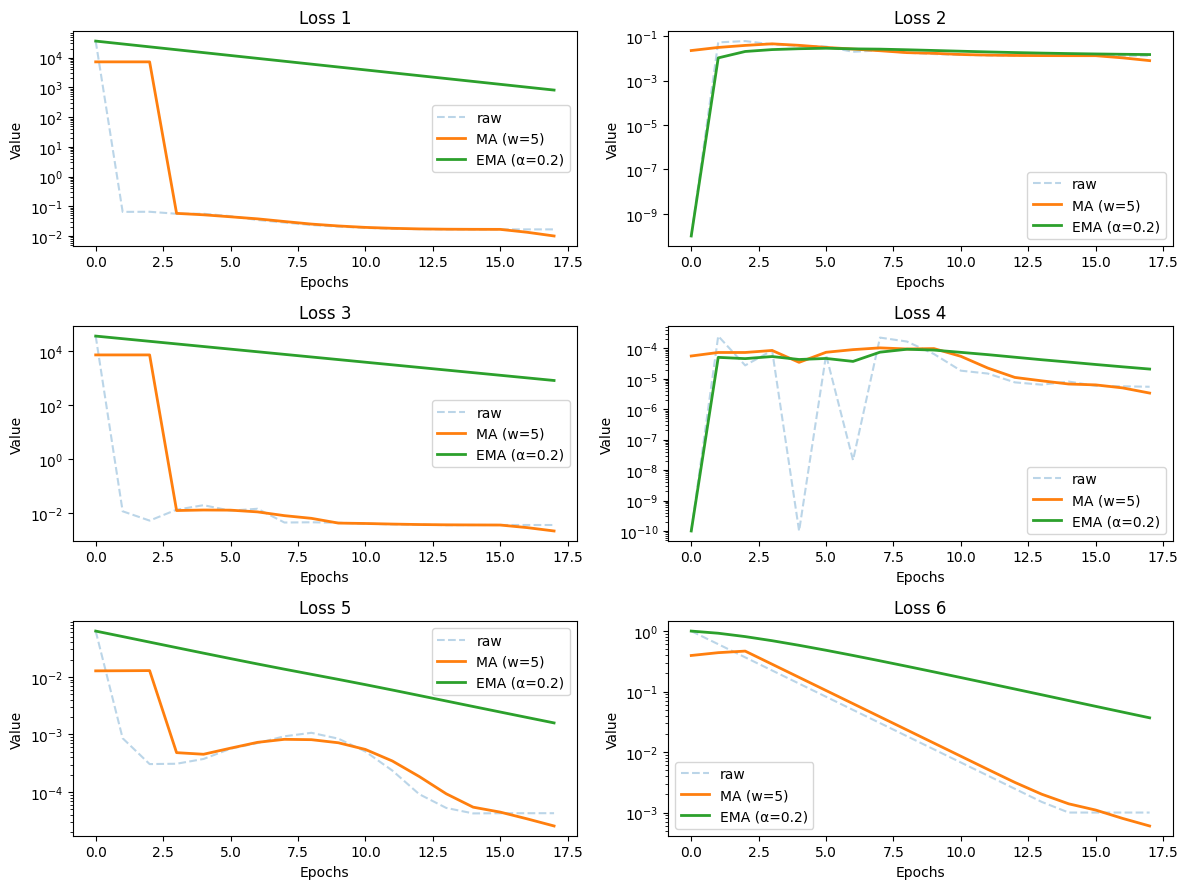

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def moving_average(x, w=5):
    # simple centered moving average, window w
    return np.convolve(x, np.ones(w)/w, mode='same')

def exp_smooth(x, alpha=0.2):
    # exponential smoothing
    s = np.zeros_like(x)
    s[0] = x[0]
    for t in range(1, len(x)):
        s[t] = alpha*x[t] + (1-alpha)*s[t-1]
    return s

fig, axs = plt.subplots(3, 2, figsize=(12, 9))
axs = axs.flatten()

window   = 5     # moving-average window
alpha    = 0.2   # smoothing factor for EMA

for i, ax in enumerate(axs):
    y = losses[:, i]

    # 1) raw
    ax.plot(y,      alpha=0.3, label='raw', linestyle='--')

    # 2) moving average
    y_ma = moving_average(y, w=window)
    ax.plot(y_ma,   linewidth=2,  label=f'MA (w={window})')

    # 3) exponential smoothing
    y_esm = exp_smooth(y, alpha=alpha)
    ax.plot(y_esm,  linewidth=2,  label=f'EMA (α={alpha})')

    ax.set_title(f'Loss {i+1}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Value')
    ax.set_yscale('log')     # optional: log-scale to compress spikes
    ax.legend()

plt.tight_layout()
plt.show()
